In [9]:
from PIL import Image
import requests
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d


In [10]:
#Select which face you want to use, you can use one from the web or from your local directory.
#The image will be trimmed square in order to calculate the diaphony!
#So square pictures are preferred.

#Web Image
original=Image.open(requests.get("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fbiografia24.pl%2Fwp-content%2Fuploads%2F2013%2F03%2FAlbert_Einstein_Head-150x150.jpg&f=1&nofb=1", stream=True).raw)

#Local image
#original=Image.open('local_image.png')


In [11]:
#if you have the sklearn package installed, it can calculate the diaphony of the face for you.
#The Kmeans is needed to turn the Turing pattern into a pointset to calculate the diaphony of.
calc_diaphony=True
try:
  from sklearn.cluster import KMeans
except:
  calc_diaphony=False

#Turing pattern making

In [12]:
def apply_kernel(kernel,img):
  return convolve2d(img,kernel, boundary='wrap', mode='same')

def turing(img,high_pass_filter,gaus_kernel):
  img=apply_kernel(high_pass_filter,img)
  img=(img > 0.5).astype('int')
  img=apply_kernel(gaus_kernel,img)
  return img  

def square_up_image(img):
  n,m=img.size
  if n==m:
    return img
  elif n>m:
    diff=n-m
    if diff%2==0:
      return img.crop((diff//2,0,n-diff//2,m))
    else:
      return img.crop((diff//2,0,n-(1+diff//2),m))
  else:
    diff=m-n 
    if diff%2==0:
      return img.crop((0,diff//2,n,m-diff//2))
    else:
      return img.crop((0,diff//2,n,m-(1+diff//2)))

def Turning_your_Face(original_image=original,inverse=False):

  if calc_diaphony:
    original_image=square_up_image(original_image)

  n,m=original_image.size
  if n>200:
    aspect_ratio=m/n
    new_size=(200,int(200*aspect_ratio))
    original_image=original_image.resize(new_size)
  seed=np.mean(np.asarray(original_image),axis=2)/255

  kernel_size=int(n/15)
  if kernel_size%2==0:
    kernel_size+=1
  kernel_size=9

  threshold=0.5

  hpf_size=kernel_size
  high_pass_filter=np.zeros((hpf_size,hpf_size))
  for i in range(hpf_size):
    for j in range(hpf_size):
      distance =  np.sqrt((i-hpf_size//2)**2 + (j-hpf_size//2)**2)
      if distance !=0:
        high_pass_filter[i,j] = -1/distance
  high_pass_filter[hpf_size//2,hpf_size//2] = -np.sum(high_pass_filter)

  gb_size=kernel_size
  t=np.linspace(-1,1,gb_size)
  bump=np.exp(-1*t**2)
  gaus_kernel=bump[:,np.newaxis]*bump[np.newaxis,:]
  gaus_kernel/=np.sum(gaus_kernel)

  turing_pattern=seed.copy()

  difference=1
  turing_iterations=0
  while turing_iterations < 50:
    result=turing(turing_pattern,high_pass_filter,gaus_kernel)
    if np.sum(result-turing_pattern)==0:
      break
    turing_iterations+=1
    turing_pattern=result
  turing_pattern=apply_kernel(high_pass_filter,turing_pattern)
  turing_pattern=(turing_pattern > threshold).astype('int')



  plt.figure(figsize=(10,10))
  plt.imshow(original_image)
  plt.imshow(np.ma.masked_array(data=turing_pattern,mask=1-turing_pattern),cmap='Greys',alpha=0.5)
  plt.xticks([])  
  plt.yticks([])  

  if calc_diaphony:
    pointset=custom_centering(turing_pattern,kernel_size)
    diaphony=calc_T_G(pointset)
    plt.title('The diaphony of your face is {0:.3f}'.format(diaphony),fontsize=30)

  plt.show()

  

  return turing_pattern


#create pointset and calculate diaphony

In [13]:
def calc_T_G(xs,plot=False):
  n=len(xs)

  s=0.5
  T_guilliver=0
  for j in range(n):
    for k in range(j):
      T_guilliver+=beta_gulliver(xs[j]-xs[k])
  T_guilliver=(T_guilliver*2+n)/n
  if plot:
    plt.scatter(xs[:,0],xs[:,1])
    plt.title('n={0}, T_G={1}'.format(n,T_guilliver))
    plt.show()
  else:
    return T_guilliver

def beta_gulliver(x,s=0.5):
  dims=2
  pre_term=1/(((1+s)/(1-s))**dims - 1)
  term=np.zeros(dims)
  for i in range(dims):
    term[i]=(1-s**2)/(1-2*s*np.cos(2*np.pi*x[i])+s**2)
  product=np.product(term)
  return pre_term*(-1+product)

In [14]:
def find_valid_neighbours(i,j,img,checked,n):
  neighbours=[[i-1,j],[i+1,j],[i,j-1],[i,j+1]]
  neighbours=[coord for coord in neighbours if img[coord[0]%n,coord[1]%n] == 1 and checked[coord[0]%n,coord[1]%n] == 0]
  return neighbours

In [15]:
def custom_centering(img,kernel_size):
  checked=np.zeros(img.shape)
  n,m=img.shape
  centers_custom=[]
  for i in range(n):
    for j in range(n):
      if checked[i,j]==0:
        if img[i,j]==1:
          blob=[]
          blob.append([i,j]) 
          checked[i,j]=1
          neighbours=find_valid_neighbours(i,j,img,checked,n)
          while len(neighbours) !=0:
            blob=np.concatenate((blob,neighbours))
            for neighbour in neighbours:
              checked[neighbour[0]%n,neighbour[1]%n]=1
            new_neighbours=[]
            for neighbour in neighbours:
              temp_neighbours=find_valid_neighbours(neighbour[0],neighbour[1],img,checked,n)
              if len(temp_neighbours) !=0:
                for temp_neighbour in temp_neighbours:
                  new_neighbours.append(temp_neighbour)
            neighbours=new_neighbours
            if len(neighbours)!=0:
              neighbours=np.unique(neighbours,axis=0)

          k=int(1+len(blob)//(1.*kernel_size**2))

          kmeans = KMeans(init="random", n_clusters=k, n_init=10, max_iter=100, random_state=42,verbose=0)
          kmeans.fit(blob)
          for center in kmeans.cluster_centers_:
            centers_custom.append(center%n)



  return np.array(centers_custom)/n      

#Turing your face

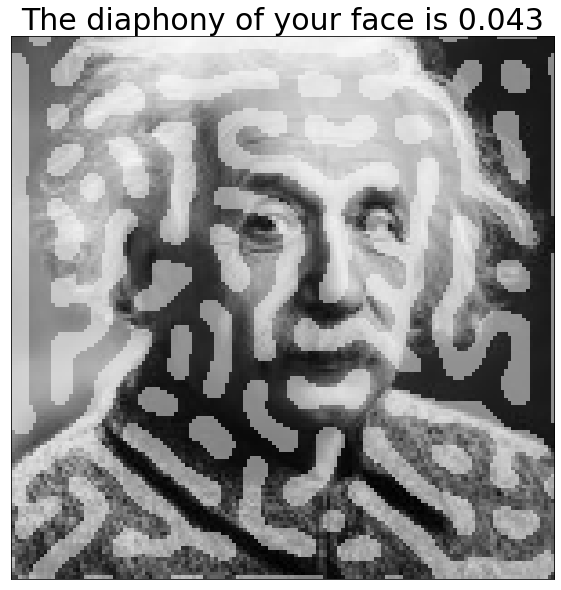

In [16]:
if __name__ == "__main__":
  turing_pattern=Turning_your_Face(original)